In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
words=open("names.txt").read().splitlines()

In [3]:
# lets make sring to charachters and charachters to string
char=sorted(list(set("".join(words))))
stoi={s:i+1 for i,s in enumerate(char)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}

In [4]:
vocab_size=len(itos)
vocab_size

27

In [5]:
import random
random.seed(42)

In [6]:
block_size=3

def build_dataset(words):
    X,Y=[],[]
    for w in words:
        context=[0]*3
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    #print(X,Y)
    return X,Y
    
random.shuffle(words)

n1=int(0.8*len(words))
n2=int(0.9*len(words))

xtr,ytr=build_dataset(words[:n1])
xval,yval=build_dataset(words[n1:n2])
xtest,ytest=build_dataset(words[n2:])

In [7]:
xtr.shape,ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [8]:
# MLP revisited
g=torch.Generator().manual_seed(2147483647)
emb_size=10
n_hidden=200

C=torch.randn((vocab_size,emb_size),generator=g)
W1=torch.randn((emb_size*block_size),n_hidden,generator=g)
b1=torch.randn(n_hidden,generator=g)
W2=torch.randn((n_hidden,vocab_size),generator=g)
b2=torch.randn(vocab_size,generator=g)
parameters=[C,W1,b1,W2,b2]

In [9]:
print(sum(p.nelement() for p in parameters))

11897


In [10]:
for p in parameters:
    p.requires_grad=True

In [11]:
# lets train on batches
batch_sz=32
lossi=[]
max_steps=2000

for i in range(max_steps):
    #during the training dataset
    ix=torch.randint(0,xtr.shape[0],(batch_sz,),generator=g)
    xb,yb=xtr[ix],ytr[ix]
    
    #feed forward part
    emb=C[xb]
    emb_temp=emb.view(emb.shape[0],-1)
    hpreact=emb_temp @W1+b1
    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,yb)

    #backward pass
    for p in parameters:
        p.grad=None
        
    loss.backward()
    #update the parameters
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    
    #lets show case out models progress
    if i==10000:
        print(f"{i:7d}/{max_steps:7d} the loss is {loss.item():.3f}")
    lossi.append(loss.log10().item())

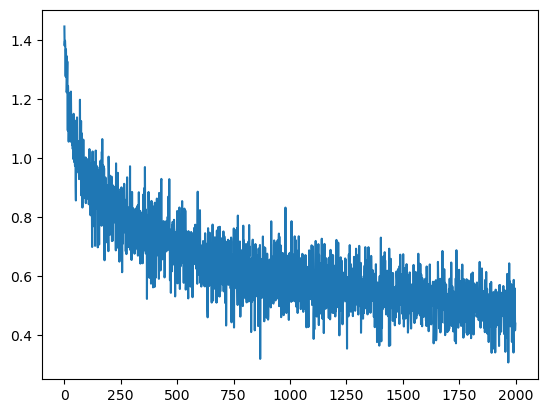

In [12]:
plt.plot(lossi)

In [13]:
# lets check for loss on the train and validation set
@torch.no_grad()
def split_loss(split):
    x,y={
        "train":(xtr,ytr),
        "valid":(xval,yval),
        "test":(xtest,ytest)
    }[split]
    emb=C[x] 
    embcat=emb.view(emb.shape[0],-1)
    h=torch.tanh(embcat@W1+b1)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss("train")
split_loss("valid")

train 3.0052521228790283
valid 3.01952862739563


In [14]:
# sample from the model
for _ in range(25):
    out=[]
    context=[0]*block_size
    while True:
        emb=C[torch.tensor([context])]
        embcat=emb.view(emb.shape[0],-1) 
        h=torch.tanh(embcat@W1+b1)
        logits=h@W2+b2
        probs=F.softmax(logits,dim=1)
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print("".join(itos[i]  for i in out))

jane.
adayle.
marioon.
chankell.
zijiannal.
kavinn.
jinxician.
hartamariamie.
naxsen.
abdlrete.
ror.
aimws.
kin.
samry.
rosa.
arrryksasye.
kayzlah.
ollianar.
fligy.
rramardrysowandan.
jacoan.
ora.
raode.
rat.
heah.


# lets try to fix our model starting with initialization

## here we are trying the weight initialization problem

In [15]:
g=torch.Generator().manual_seed(2147483647)
emb_size=10
n_hidden=200

C=torch.randn((vocab_size,emb_size),generator=g)
W1=torch.randn((emb_size*block_size),n_hidden,generator=g)
b1=torch.randn(n_hidden,generator=g)
W2=torch.randn((n_hidden,vocab_size),generator=g)*0.01
b2=torch.randn(vocab_size,generator=g)*0
parameters=[C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad=True

In [16]:
hpreact.shape

torch.Size([32, 200])

In [17]:
# lets train on batches
batch_sz=32
lossi=[]
max_steps=20000

for i in range(max_steps):
    #during the training dataset
    ix=torch.randint(0,xtr.shape[0],(batch_sz,),generator=g)
    xb,yb=xtr[ix],ytr[ix]
    
    #feed forward part
    emb=C[xb]
    emb_temp=emb.view(emb.shape[0],-1)
    hpreact=emb_temp @W1+b1
    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,yb)

    #backward pass
    for p in parameters:
        p.grad=None
        
    loss.backward()
    #update the parameters
    lr=0.1 if i<100 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    
    #lets show case out models progress
    if i%15000==0:
        print(f"{i:7d}/{max_steps:7d} the loss is {loss.item():.3f}")
    lossi.append(loss.log10().item())

      0/  20000 the loss is 3.322
  15000/  20000 the loss is 2.325


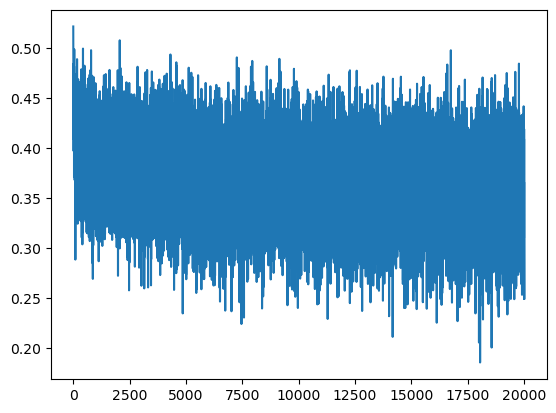

In [18]:
plt.plot(lossi)

In [19]:
split_loss("train")
split_loss("valid")

train 2.2800071239471436
valid 2.2877113819122314


## the activation function part

In [45]:
g=torch.Generator().manual_seed(2147483647)
emb_size=10
n_hidden=200

C=torch.randn((vocab_size,emb_size),generator=g)
W1=torch.randn((emb_size*block_size),n_hidden,generator=g)* (3/5)/(emb_size*vocab_size)**0.5
b1=torch.randn(n_hidden,generator=g)*0
W2=torch.randn((n_hidden,vocab_size),generator=g)*0.01
b2=torch.randn(vocab_size,generator=g)*0
parameters=[C,W1,b1,W2,b2]

for p in parameters:
    p.requires_grad=True

In [46]:
hpreact.shape

torch.Size([32, 200])

In [47]:
# lets train on batches
batch_sz=32
lossi=[]
max_steps=1000

for i in range(max_steps):
    #during the training dataset
    ix=torch.randint(0,xtr.shape[0],(batch_sz,),generator=g)
    xb,yb=xtr[ix],ytr[ix]
    
    #feed forward part
    emb=C[xb]
    emb_temp=emb.view(emb.shape[0],-1)
    hpreact=emb_temp @W1+b1
    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,yb)

    #backward pass
    for p in parameters:
        p.grad=None
        
    loss.backward()
    #update the parameters
    lr=0.1 if i<100 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    
    #lets show case out models progress
    if i%10000==0:
        print(f"{i:7d}/{max_steps:7d} the loss is {loss.item():.3f}")
    lossi.append(loss.log10().item())

      0/   1000 the loss is 3.300


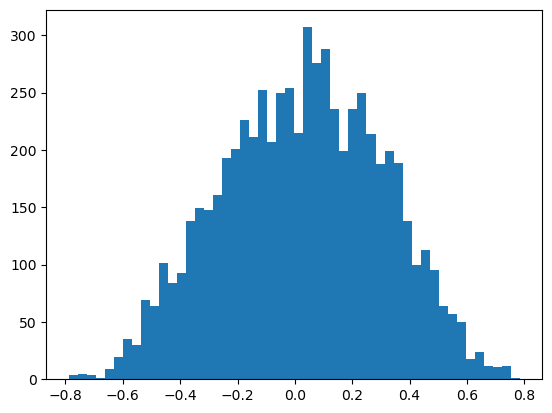

In [23]:
plt.hist(h.view(-1).tolist(),50);

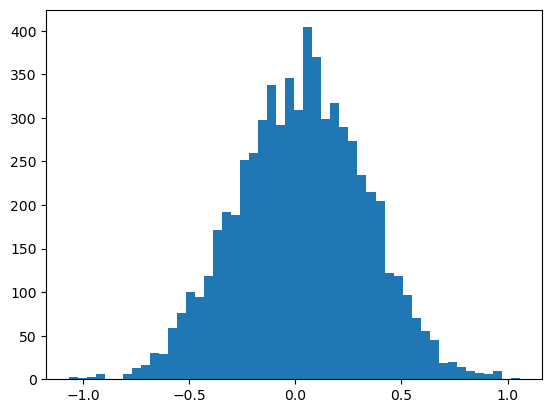

In [24]:
plt.hist(hpreact.view(-1).tolist(),50);

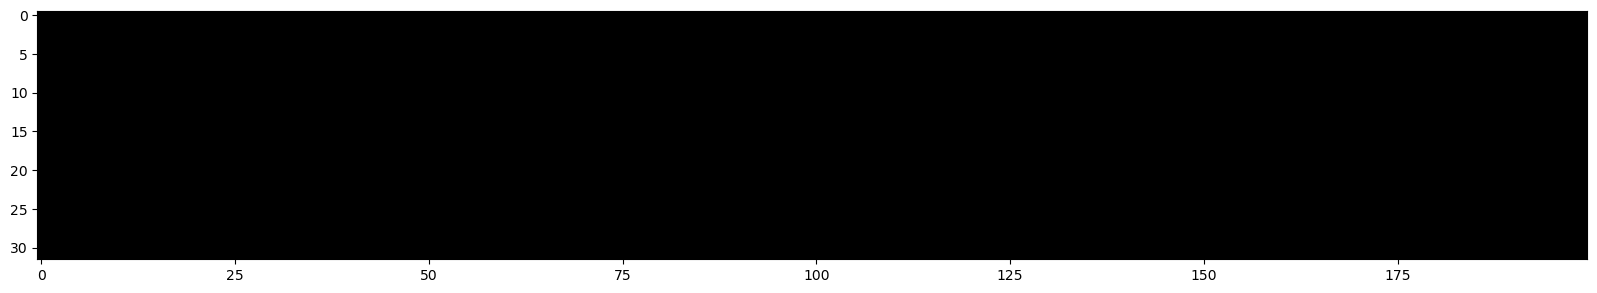

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap="gray",interpolation="nearest")

In [26]:
split_loss("train")
split_loss("valid")

train 2.618420124053955
valid 2.616450071334839


### Batch Normalization

In [83]:
g=torch.Generator().manual_seed(2147483647)
emb_size=10
n_hidden=200

C=torch.randn((vocab_size,emb_size),generator=g)
W1=torch.randn((emb_size*block_size),n_hidden,generator=g)* (3/5)/(emb_size*vocab_size)**0.5
b1=torch.randn(n_hidden,generator=g)*0
W2=torch.randn((n_hidden,vocab_size),generator=g)*0.01
b2=torch.randn(vocab_size,generator=g)*0

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))

bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

parameters=[C,W1,b1,W2,b2,bngain,bnbias]

for p in parameters:
    p.requires_grad=True

In [94]:
# lets train on batches
batch_sz=32
lossi=[]
max_steps=10000

for i in range(max_steps):
    #during the training dataset
    ix=torch.randint(0,xtr.shape[0],(batch_sz,),generator=g)
    xb,yb=xtr[ix],ytr[ix]
    
    #feed forward part
    emb=C[xb]
    emb_temp=emb.view(emb.shape[0],-1)
    hpreact=emb_temp @W1+b1
    
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=hpreact-bnmeani/bnstdi+bnbias
    
    with torch.no_grad():
        bnmean_running=0.999*bnmean_running+0.001*bnmeani
        bnstd_running=0.999*bnstd_running+0.001*bnstdi
        
    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,yb)

    #backward pass
    for p in parameters:
        p.grad=None
        
    loss.backward()
    #update the parameters
    #lr=0.1 if i<1000 else 0.01
    for p in parameters:
        if p.grad is not None:
            p.data += -0.01*p.grad
    
    #lets show case out models progress
    if i%1000==0:
        print(f"{i:7d}/{max_steps:7d} the loss is {loss.item():.3f}")
    lossi.append(loss.log10().item())

      0/  10000 the loss is 2.106
   1000/  10000 the loss is 2.273
   2000/  10000 the loss is 1.913
   3000/  10000 the loss is 2.297
   4000/  10000 the loss is 1.993
   5000/  10000 the loss is 2.375
   6000/  10000 the loss is 2.234
   7000/  10000 the loss is 2.355
   8000/  10000 the loss is 2.702
   9000/  10000 the loss is 2.387


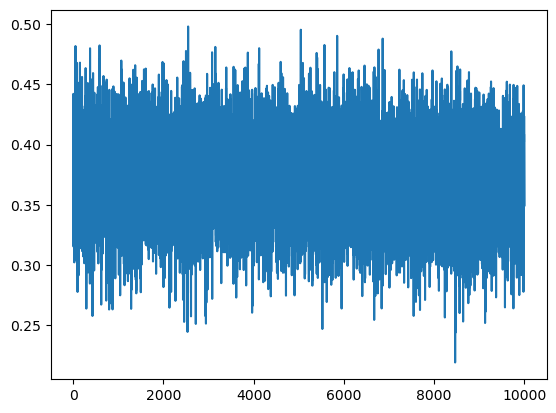

In [95]:
plt.plot(lossi)

In [92]:
# calculates the mean and std over the training set
with torch.no_grad():
    emb=C[xtr]
    embcat=emb.view(xtr.shape[0],-1)
    hpreact=embcat@W1+b1
    bnmean=hpreact.mean(0,keepdim=True)  #this is the batch mean
    bnstd=hpreact.std(0,keepdim=True)

In [93]:
@torch.no_grad()
def split_loss(split):
    x,y={
        "train":(xtr,ytr),
        "valid":(xval,yval),
        "test":(xtest,ytest)
    }[split]
    emb=C[x] 
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@W1+b1
    hpreact=bngain*(hpreact-bnmean_running)/bnstd_running+bnbias
    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss("train")
split_loss("valid")

train 2.7480545043945312
valid 2.7440273761749268
